In [ ]:
!pip install tensorflow pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten


In [ ]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')

print(df.info())
df.head()


<class 'pandas.core.frame.DataFrame'>
Index: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   holiday              61 non-null     object        
 1   temp                 48204 non-null  float64       
 2   rain_1h              48204 non-null  float64       
 3   snow_1h              48204 non-null  float64       
 4   clouds_all           48204 non-null  int64         
 5   weather_main         48204 non-null  object        
 6   weather_description  48204 non-null  object        
 7   date_time            48204 non-null  datetime64[ns]
 8   traffic_volume       48204 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 3.7+ MB
None


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [ ]:
# Extract time features
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['holiday', 'weather_main'], drop_first=True)

# Drop unused text columns
df = df.drop(columns=['weather_description', 'date_time'])

# Check final columns
df.head()


,temp,rain_1h,snow_1h,clouds_all,traffic_volume,hour,dayofweek,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,0.0,0.0,40,5545,9,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,4516,10,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,4767,11,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,5026,12,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,4918,13,1,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, list(df.columns).index('traffic_volume')])  # predict traffic_volume
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_steps=24)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape, X_test.shape)



(38544, 24, 27) (9636, 24, 27)


In [ ]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=15,
                              batch_size=32,
                              validation_split=0.1,
                              verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 62s 53ms/step - loss: 0.0307 - val_loss: 0.0063
Epoch 2/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 79s 51ms/step - loss: 0.0087 - val_loss: 0.0045
Epoch 3/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - loss: 0.0075 - val_loss: 0.0039
Epoch 4/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 83s 47ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 5/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 6/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0057 - val_loss: 0.0032
Epoch 7/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 8/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 9/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0055 - val_loss: 0.0030
Epoch 10/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 11/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 46ms/step - loss: 0.0050 - val_loss: 0.0030
Epoch 12

In [ ]:
model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_cnn_lstm.compile(optimizer='adam', loss='mse')

history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train,
                                      epochs=15,
                                      batch_size=32,
                                      validation_split=0.1,
                                      verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 0.0467 - val_loss: 0.0068
Epoch 2/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0103 - val_loss: 0.0053
Epoch 3/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0085 - val_loss: 0.0057
Epoch 4/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0072 - val_loss: 0.0058
Epoch 5/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 6/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 7/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 8/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0055 - val_loss: 0.0038
Epoch 9/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 10/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 11/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - loss: 0.0052 - val_loss: 0.0036
Epoch 12

In [ ]:
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse scale for traffic_volume only
    traffic_index = list(df.columns).index('traffic_volume')
    dummy_test = np.zeros((len(y_test), scaled_data.shape[1]))
    dummy_test[:, traffic_index] = y_test
    y_test_inv = scaler.inverse_transform(dummy_test)[:, traffic_index]

    dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
    dummy_pred[:, traffic_index] = y_pred[:, 0]
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, traffic_index]

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100

    return rmse, mape, y_test_inv, y_pred_inv


In [ ]:
rmse_lstm, mape_lstm, y_test_inv_lstm, y_pred_inv_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
rmse_cnn, mape_cnn, y_test_inv_cnn, y_pred_inv_cnn = evaluate_model(model_cnn_lstm, X_test, y_test, scaler)

print(f"LSTM Model → RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%")
print(f"CNN+LSTM Model → RMSE: {rmse_cnn:.2f}, MAPE: {mape_cnn:.2f}%")


302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
LSTM Model → RMSE: 372.32, MAPE: 13.13%
CNN+LSTM Model → RMSE: 389.31, MAPE: 14.97%


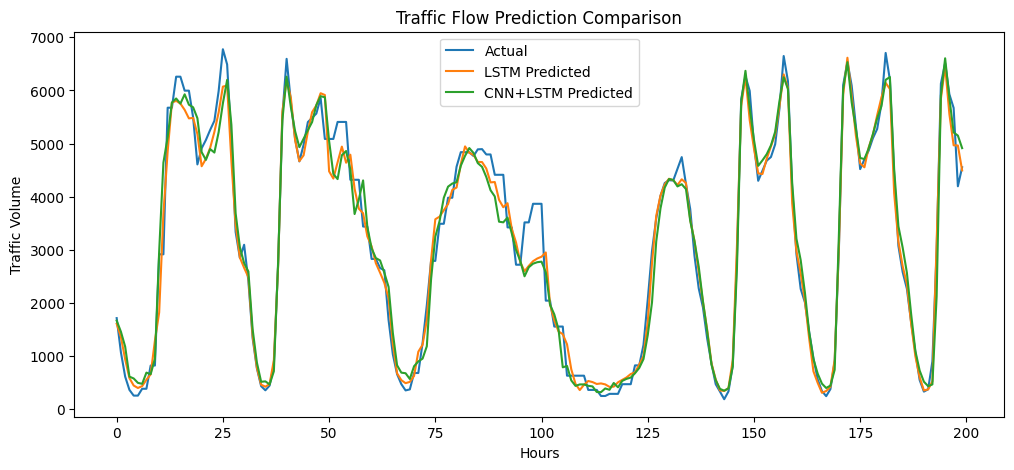

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test_inv_lstm[:200], label='Actual')
plt.plot(y_pred_inv_lstm[:200], label='LSTM Predicted')
plt.plot(y_pred_inv_cnn[:200], label='CNN+LSTM Predicted')
plt.xlabel('Hours')
plt.ylabel('Traffic Volume')
plt.title('Traffic Flow Prediction Comparison')
plt.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 8380612.5000
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3920140.2500
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3911492.5000
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3883375.7500
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 3888080.2500
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3865219.0000
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3871691.5000
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3880968.2500
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3823119.7500
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 3819211.2500
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 7080491.5000
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3950314.0000
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3909558.7500
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4665796.5000
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3933787.5000
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3981216.7500
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3961402.0000
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3912849.7500
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3962019.7500
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3917243.2500
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 6966534.5000
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 3970893.5000
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3923675.5000
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 3930481.0000
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 3922128.5000
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3928755.5000
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3926075.2500
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 3905418.7500
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3901041.2500
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 3868179.0000
302/302 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
                 RMSE    MAPE (%)        R²
LSTM      1928.924960  169.154811  0.038993
CNN+LSTM  1955.071738  159.823024  0.012763
GRU       1943.364994  157.291865  0.024551
XGBoost   1877.254112  155.

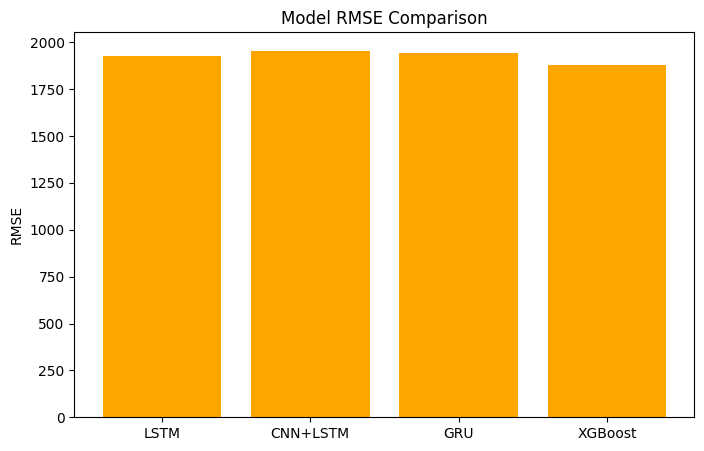

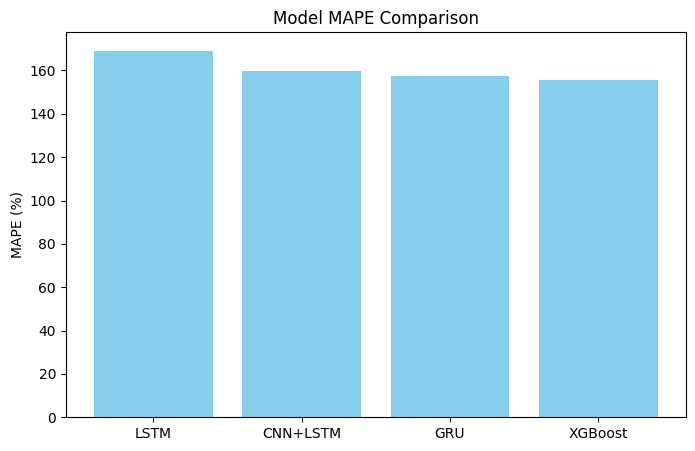

In [ ]:
# =======================================
# 1. Install & Import Libraries
# =======================================
!pip install xgboost tensorflow

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, GRU, Dropout
from xgboost import XGBRegressor

# =======================================
# 2. Load Your Dataset
# =======================================
# Replace with your actual CSV
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

# =======================================
# 3. Data Preprocessing
# =======================================
# Encode categorical variables
cat_cols = ['holiday', 'weather_main', 'weather_description']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

# Convert date_time to datetime
df['date_time'] = pd.to_datetime(df['date_time'])
df.sort_values('date_time', inplace=True)

# Features & Target
X = df.drop(columns=['traffic_volume', 'date_time'])
y = df['traffic_volume']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape for RNN/CNN models
X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Function for metrics
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mape, r2

results = {}

# =======================================
# 4. Model 1 - LSTM
# =======================================
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_seq)
results['LSTM'] = evaluate_model(y_test, y_pred_lstm)

# =======================================
# 5. Model 2 - CNN+LSTM
# =======================================
cnn_lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu'),
    Dense(1)
])
cnn_lstm_model.compile(optimizer='adam', loss='mse')
cnn_lstm_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test_seq)
results['CNN+LSTM'] = evaluate_model(y_test, y_pred_cnn_lstm)

# =======================================
# 6. Model 3 - GRU
# =======================================
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(X_train_seq.shape[1], 1)),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train_seq, y_train, epochs=10, batch_size=32, verbose=1)
y_pred_gru = gru_model.predict(X_test_seq)
results['GRU'] = evaluate_model(y_test, y_pred_gru)

# =======================================
# 7. Model 4 - XGBoost
# =======================================
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
results['XGBoost'] = evaluate_model(y_test, y_pred_xgb)

# =======================================
# 8. Results Table
# =======================================
results_df = pd.DataFrame(results, index=['RMSE', 'MAPE (%)', 'R²']).T
print(results_df)

# =======================================
# 9. Plot Comparison
# =======================================
plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['RMSE'], color='orange')
plt.title("Model RMSE Comparison")
plt.ylabel("RMSE")
plt.show()

plt.figure(figsize=(8,5))
plt.bar(results_df.index, results_df['MAPE (%)'], color='skyblue')
plt.title("Model MAPE Comparison")
plt.ylabel("MAPE (%)")
plt.show()
